# SBI with trial-based data and models of mixed data types

Trial-based data often has the property that the individual trials can be assumed to be independent and identically distributed (iid), i.e., they are assumed to have the same underlying model parameters. For example, in a decision-making experiments, the experiment is often repeated in trials with the same experimental settings and conditions. The corresponding set of trials is then assumed to be "iid". 


### Amortization of neural network training with likelihood-based SBI
For some SBI variants the iid assumption can be exploited: when using a likelihood-based SBI method (`SNLE`, `SNRE`) one can train the density or ratio estimator on single-trial data, and then perform inference with `MCMC`. Crucially, because the data is iid and the estimator is trained on single-trial data, one can repeat the inference with a different `x_o` (a different set of trials, or different number of trials) without having to retrain the density estimator. One can interpet this as amortization of the SBI training: we can obtain a neural likelihood, or likelihood-ratio estimate for new `x_o`s without retraining, but we still have to run `MCMC` or `VI` to do inference. 

In addition, one can not only change the number of trials of a new `x_o`, but also the entire inference setting. For example, one can apply hierarchical inference scenarios with changing hierarchical denpendencies between the model parameters--all without having to retrain the density estimator because that is based on estimating single-trail likelihoods.

Let us first have a look how trial-based inference works in `SBI` before we discuss models with "mixed data types".

## SBI with trial-based data

For illustration we use a simple linear Gaussian simulator, as in previous tutorials. The simulator takes a single parameter (vector), the mean of the Gaussian and its variance is set to one. We define a Gaussian prior over the mean and perform inference. The observed data is again a from a Gaussian with some fixed "ground-truth" parameter $\theta_o$. Crucially, the observed data `x_o` can consist of multiple samples given the same ground-truth parameters and these samples are then iid: 

$$ 
\theta \sim \mathcal{N}(\mu_0,\; \Sigma_0) \\
x | \theta \sim \mathcal{N}(\theta,\; \Sigma=I) \\
\mathbf{x_o} = \{x_o^i\}_{i=1}^N \sim  \mathcal{N}(\theta_o,\; \Sigma=I)
$$

For this toy problem the ground-truth posterior is well defined, it is again a Gaussian, centered on the mean of $\mathbf{x_o}$ and with variance scaled by the number of trials $N$, i.e., the more trials we observe, the more information about the underlying $\theta_o$ we have and the more concentrated the posteriors becomes.

We will illustrate this below:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import zeros, ones, eye
from torch.distributions import MultivariateNormal
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.analysis import pairplot
from sbi.utils.metrics import c2st

from sbi.simulators.linear_gaussian import linear_gaussian, true_posterior_linear_gaussian_mvn_prior

# Seeding
torch.manual_seed(1);

In [2]:
# Gaussian simulator
theta_dim = 2
x_dim = theta_dim

# likelihood_mean will be likelihood_shift+theta
likelihood_shift = -1.0 * zeros(x_dim)
likelihood_cov = 0.3 * eye(x_dim)

prior_mean = zeros(theta_dim)
prior_cov = eye(theta_dim)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)

# Define Gaussian simulator
simulator, prior = prepare_for_sbi(lambda theta: linear_gaussian(theta, likelihood_shift, likelihood_cov), prior)

# Use built-in function to obtain ground-truth posterior given x_o
def get_true_posterior_samples(x_o, num_samples=1):
    return true_posterior_linear_gaussian_mvn_prior(x_o, 
                                                    likelihood_shift, 
                                                    likelihood_cov, 
                                                    prior_mean, 
                                                    prior_cov).sample((num_samples,))

### The analytical posterior concentrates around true parameters with increasing number of IID trials 

In [3]:
num_trials = [1, 5, 15, 20]
theta_o = zeros(1, theta_dim)

# Generate multiple x_os with increasing number of trials.
xos = [theta_o.repeat(nt, 1) for nt in num_trials]

# Obtain analytical posterior samples for each of them.
ss = [get_true_posterior_samples(xo, 5000) for xo in xos]

/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


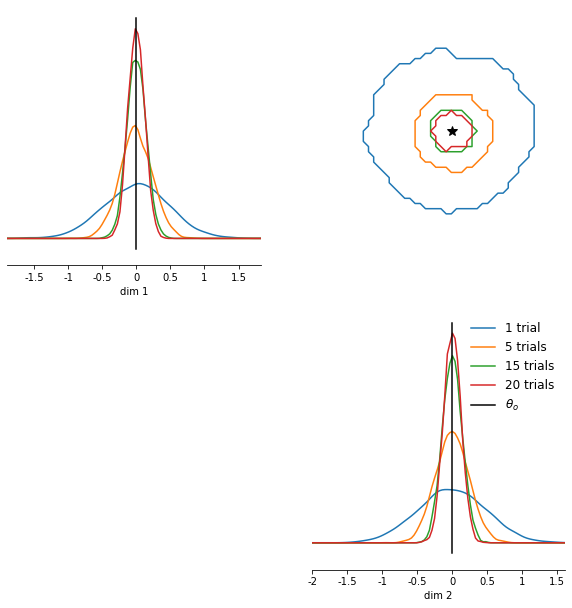

In [4]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(ss, 
                   points=theta_o, 
                   diag="kde",
                   upper="contour", 
                   kde_offdiag=dict(bins=50),
                   kde_diag=dict(bins=100),
                   contour_offdiag=dict(levels=[0.95]),
                   points_colors=["k"], 
                   points_offdiag=dict(marker="*", markersize=10), 
                  )
plt.sca(ax[1, 1])
plt.legend([f"{nt} trials" if nt>1 else f"{nt} trial" for nt in num_trials] + [r"$\theta_o$"], 
           frameon=False, 
           fontsize=12,
          );

Indeed, with increasing number of trials the posterior density concentrates around the true underlying parameter.

## Trial-based inference with NLE

(S)NLE can easily perform inference given multiple IID x because it is based on learning the likelihood. Once the likelihood is learned on single trials, i.e., a neural network that given a single observation and a parameter predicts the likelihood of that observation given the parameter, one can perform MCMC to obtain posterior samples. 

MCMC relies on evaluating ratios of likelihoods of candidate parameters to either accept or reject them to be posterior samples. When inferring the posterior given multiple IID observation, these likelihoods are just the joint likelihoods of each IID observation given the current parameter candidate. Thus, given a neural likelihood from SNLE, we can calculate these joint likelihoods and perform MCMC given IID data, we just have to multiply together (or add in log-space) the individual trial-likelihoods (`sbi` takes care of that).

In [5]:
# Train SNLE.
inferer = SNLE(prior, show_progress_bars=True, density_estimator="mdn")
theta, x = simulate_for_sbi(simulator, prior, 10000, simulation_batch_size=1000)
inferer.append_simulations(theta, x).train(training_batch_size=100);

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 40 epochs.

In [6]:
# Obtain posterior samples for different number of iid xos. 
samples = []
num_samples = 5000

mcmc_parameters = dict(
    num_chains = 50,
    thin = 10,
    warmup_steps = 50,
    init_strategy = "proposal",
)
mcmc_method = "slice_np_vectorized"

posterior = inferer.build_posterior(
        mcmc_method=mcmc_method, 
        mcmc_parameters=mcmc_parameters,
    )

# Generate samples with MCMC given the same set of x_os as above.
for xo in xos:
    samples.append(posterior.sample(sample_shape=(num_samples,), x=xo))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75000/75000 [00:34<00:00, 2173.97it/s]
/home/janfb/qode/sbi/sbi/utils/sbiutils.py:282: UserWarning: An x with a batch size of 5 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  respect to entire batch, i.e,. p(theta | X)."""
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75000/75000 [00:40<00:00, 1871.97it/s]
/home/janfb/qode/sbi/sbi/utils/sbiutils.py:282: UserWarning: An x with a batch size of 15 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_

Note that `sbi` warns about `iid-x` with increasing number of trial here. We ignore the warning because that's exactly what we want to do.

/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


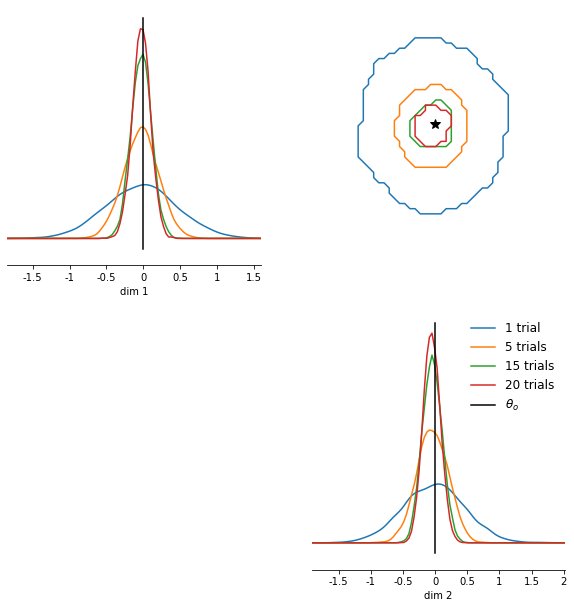

In [7]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(samples, 
                   points=theta_o, 
                   diag="kde",
                   upper="contour", 
                   kde_offdiag=dict(bins=50),
                   kde_diag=dict(bins=100),
                   contour_offdiag=dict(levels=[0.95]),
                   points_colors=["k"], 
                   points_offdiag=dict(marker="*", markersize=10), 
                  )
plt.sca(ax[1, 1])
plt.legend([f"{nt} trials" if nt>1 else f"{nt} trial" for nt in num_trials] + [r"$\theta_o$"], 
           frameon=False, 
           fontsize=12,
          );

The pairplot above already indicates that (S)NLE is well able to obtain accurate posterior samples also for increasing number of trials (note that we trained the single-round version of SNLE so that we did not have to re-train it for new $x_o$). 

Quantitatively we can measure the accuracy of SNLE by calculating the `c2st` score between SNLE and the true posterior samples, where the best accuracy is perfect for `0.5`:

In [8]:
cs = [c2st(torch.from_numpy(s1), torch.from_numpy(s2)) for s1, s2 in zip(ss, samples)]

for _ in range(len(num_trials)):
    print(f"c2st score for num_trials={num_trials[_]}: {cs[_].item():.2f}")

c2st score for num_trials=1: 0.51
c2st score for num_trials=5: 0.50
c2st score for num_trials=15: 0.53
c2st score for num_trials=20: 0.55


This inference procedure would work similarly when using `SNRE`. However, note that it does not work for `SNPE` because in `SNPE` we are learning the posterior directly so that whenever `x_o` changes (in terms of the number of trials or the parameter dependencies) the posterior changes and `SNPE` needs to be trained again. 

## Trial-based SBI with mixed data types

In some cases, models with trial-based data additionally return data with mixed data types, e.g., continous and discrete data. For example, most computational models of decision-making have continuous reaction times and discrete choices as output. 

This can induce a problem when performing trial-based SBI that relies on learning a neural likelihood. The problem is that it is challenging for most density estimators to handle both, continous and discrete data at the same time. There has been developed a method for solving this problem, it's called __Mixed Neural Likelihood Estimation__ (MNLE). It works just like NLE, but with mixed data types. The trick is that it learns two separate density estimators, one for the discrete part of the data, and one for the continuous part, and combines the two to obtain the final neural likelihood. Crucially, the continuous density estimator is trained conditioned on the output of the discrete one, such that statistical dependencies between the discrete and continous data (e.g., between choices and reaction times) are modeled as well. The interested reader is referred to the original paper available [here](https://www.biorxiv.org/content/10.1101/2021.12.22.473472v2).

MNLE was recently added to `sbi` (see [PR](https://github.com/mackelab/sbi/pull/638)) and follow the same API as `SNLE`.

## Toy problem for `MNLE`

To illustrate `MNLE` we set up a toy simulator that outputs mixed data and for which we know the likelihood such we can obtain reference posterior samples via MCMC.

__Simulator__: To simulate mixed data we do the following

- Sample reaction time from `inverse Gamma`
- Sample choices from `Binomial`
- Return reaction time $rt \in (0, \infty$ and choice index $c \in \{0, 1\}$

$$
c \sim \text{Binomial}(\rho) \\
rt \sim \text{InverseGamma}(\alpha=2, \beta) \\
$$




__Prior__: The priors of the two parameters $\rho$ and $\beta$ are independent. We define a `Beta` prior over the probabilty parameter of the `Binomial` used in the simulator and a `Gamma` prior over the shape-parameter of the `inverse Gamma` used in the simulator:

$$
p(\beta, \rho) = p(\beta) \; p(\rho) ; \\
p(\beta) = \text{Gamma}(1, 0.5) \\
p(\text{probs}) = \text{Beta}(2, 2) 
$$

Because the `InverseGamma` and the `Binomial` likelihoods are well-defined we can perform MCMC on this problem and obtain reference-posterior samples.

In [4]:
from sbi.inference import MNLE
from pyro.distributions import InverseGamma
from torch.distributions import Beta, Binomial, Gamma
from sbi.utils import MultipleIndependent

from sbi.inference import MCMCPosterior, VIPosterior, RejectionPosterior
from sbi.utils.torchutils import atleast_2d

from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

In [8]:
# Toy simulator for mixed data
def mixed_simulator(theta):
    beta, ps = theta[:, :1], theta[:, 1:]
    
    choices = Binomial(probs=ps).sample()
    rts = InverseGamma(concentration=2 * torch.ones_like(beta), rate=beta).sample()
    
    return torch.cat((rts, choices), dim=1)


# Potential function to perform MCMC to obtain the reference posterior samples.
class PotentialFunctionProvider(BasePotential):
    allow_iid_x = True  # type: ignore

    def __init__(self, prior, x_o, device="cpu"):
        super().__init__(prior, x_o, device)

    def __call__(self, theta, track_gradients: bool=True):

        theta = atleast_2d(theta)

        with torch.set_grad_enabled(track_gradients):
            iid_ll = self.iid_likelihood(theta)

        return iid_ll + self.prior.log_prob(theta)

    def iid_likelihood(self, theta):

        lp_choices = torch.stack([Binomial(probs=th.reshape(1, -1)).log_prob(self.x_o[:, 1:])
                                  for th in theta[:, 1:]], 
                                 dim=1)

        lp_rts = torch.stack(
            [
                InverseGamma(concentration=2 * torch.ones_like(beta_i), 
                             rate=beta_i).log_prob(self.x_o[:, :1])
                for beta_i in theta[:, :1]
            ],
            dim=1,
        )

        joint_likelihood = (lp_choices + lp_rts).squeeze()

        assert joint_likelihood.shape == torch.Size([x_o.shape[0], theta.shape[0]])
        return joint_likelihood.sum(0)


In [6]:
# Define independent prior.
prior = MultipleIndependent([Gamma(torch.tensor([1.]), torch.tensor([.5])), 
                             Beta(torch.tensor([2.0]), torch.tensor([2.0]))], 
                            validate_args=False)

### Obtain reference-posterior samples via analytical likelihood and MCMC

In [12]:
torch.manual_seed(42)
num_trials = 10
num_samples = 1000
theta_o = prior.sample((1,))
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))


In [13]:
true_posterior = MCMCPosterior(potential_fn=PotentialFunctionProvider(prior, x_o), 
                               proposal=prior,
                               method="slice_np_vectorized",
                               theta_transform=mcmc_transform(prior, enable_transform=True),
                               **mcmc_parameters,
                         )
true_samples = true_posterior.sample((num_samples,))

/home/janfb/qode/sbi/sbi/utils/sbiutils.py:282: UserWarning: An x with a batch size of 10 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  respect to entire batch, i.e,. p(theta | X)."""
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35000/35000 [02:39<00:00, 219.06it/s]


### Train MNLE and generate samples via MCMC

In [10]:
# Training data
num_simulations = 5000
theta = prior.sample((num_simulations,))
x = mixed_simulator(theta)

# Train MNLE and obtain MCMC-based posterior.
trainer = MNLE()
estimator = trainer.append_simulations(theta, x).train()

 Neural network successfully converged after 84 epochs.

In [14]:
posterior = trainer.build_posterior(estimator, prior)

In [14]:
# Training data
num_simulations = 5000
theta = prior.sample((num_simulations,))
x = mixed_simulator(theta)

# Train MNLE and obtain MCMC-based posterior.
trainer = MNLE(prior)
estimator = trainer.append_simulations(theta, x).train()
mnle_posterior = trainer.build_posterior(mcmc_method="slice_np_vectorized",
                                         mcmc_parameters=mcmc_parameters)
mnle_samples = mnle_posterior.sample((num_samples,), x=x_o)

/home/janfb/qode/sbi/sbi/neural_nets/mnle.py:64: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  this is not the case for the passed `x` do not use this function."""


 Neural network successfully converged after 35 epochs.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35000/35000 [01:26<00:00, 404.04it/s]


### Compare MNLE and reference posterior

/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


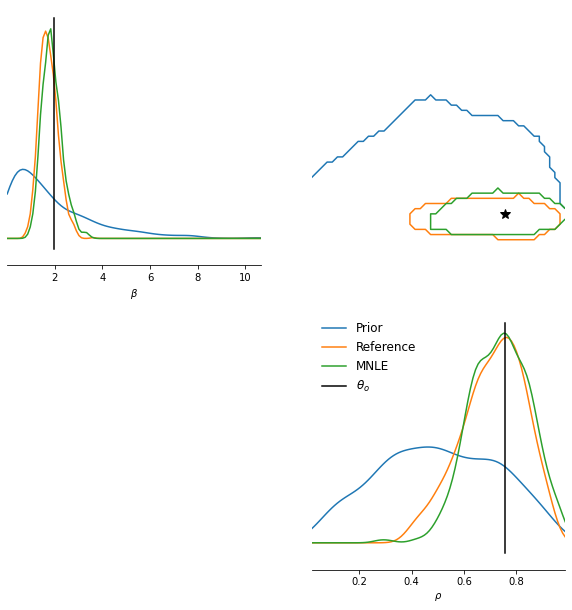

In [15]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot([
    prior.sample((1000,)),
    true_samples, 
    mnle_samples,
], 
    points=theta_o, 
    diag="kde",
    upper="contour", 
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"], 
    points_offdiag=dict(marker="*", markersize=10), 
    labels=[r"$\beta$", r"$\rho$"],
)

plt.sca(ax[1, 1])
plt.legend(["Prior", "Reference", "MNLE", r"$\theta_o$"], 
           frameon=False, 
           fontsize=12,
          );

We see that the inferred `MNLE` posterior nicely matches the reference posterior, and how both inferred a posterior that is quite different from the prior.

Because MNLE training is amortized we can obtain another posterior given a different observation with potentially a different number of trials, just by running MCMC again (without re-training `MNLE`):

### Repeat inference with different `x_o` that has more trials

In [16]:
num_trials = 100
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))
true_samples = true_posterior.sample((num_samples,), x=x_o)
mnle_samples = mnle_posterior.sample((num_samples,), x=x_o)

/home/janfb/qode/sbi/sbi/utils/sbiutils.py:282: UserWarning: An x with a batch size of 100 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  respect to entire batch, i.e,. p(theta | X)."""
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35000/35000 [08:23<00:00, 69.57it/s]


/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


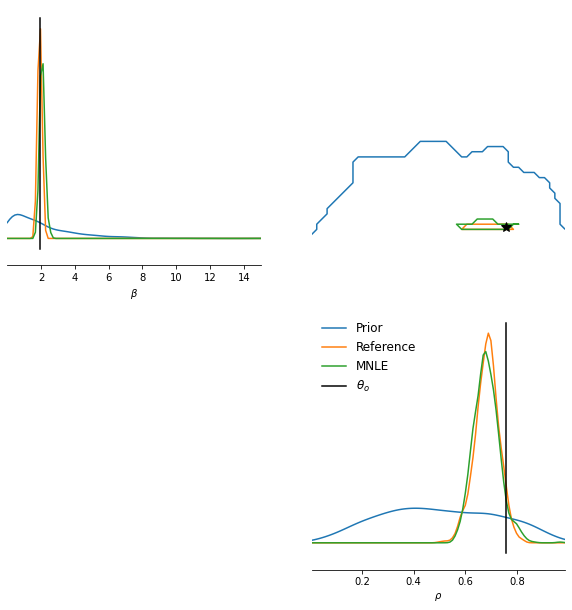

In [17]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot([
    prior.sample((1000,)),
    true_samples, 
    mnle_samples,
], 
    points=theta_o, 
    diag="kde",
    upper="contour", 
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"], 
    points_offdiag=dict(marker="*", markersize=10), 
    labels=[r"$\beta$", r"$\rho$"],
)

plt.sca(ax[1, 1])
plt.legend(["Prior", "Reference", "MNLE", r"$\theta_o$"], 
           frameon=False, 
           fontsize=12,
          );

Again we can see that the posteriors match nicely. In addition, we observe that the posterior variance reduces as we increase the number of trials, similar to the illustration with the Gaussian example at the beginning of the tutorial. 

A final note: `MNLE` is trained on single-trial data. Theoretically, density estimation is perfectly accurate only in the limit of infinite training data. Thus, training with a finite amount of training data naturally induces a small bias in the density estimator. As we observed above, this bias is so small that we don't really notice it, e.g., the `c2st` scores were close to 0.5. However, when we increase the number of trials in `x_o` dramatically (on the order of 1000s) the small bias can accumulate over the trials and inference with `MNLE` can become less accurate.